# Topological optimization of Pikachu's forehead

In this notebook, we show how a topological loss function can be use to increase the prominence of Pikachu's forehead cycle.

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import numpy as np
import pandas as pd

# Functions for deep learning (Pytorch)
import torch
from torch import nn

# Pytorch compatible topology layer
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Load and view data

We load and view the data as follows.

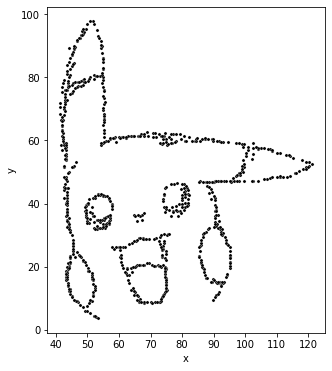

In [2]:
# Load the data
data = pd.read_csv("Pikachu.csv", delimiter=",", header=None, names=["x", "y"])

# Plot the data
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x="x", y="y", ax=ax, color="black", s=10)
ax.set_aspect("equal", "box")
plt.show()

## Apply topological optimization to the embedding

We now show how we can use topological optimization to decrease the prominence of Pikachu's forehead cycle, which corresponds to the most significant 1-dimensional hole in the point cloud. We will explore the use of the following three topological loss functions.

- The negative death time of the most prominent cycle: -d.
- The birth time of the most prominent cycle: b.
- The negative persistence of the most prominent cycle: -(d - b).

Note that all loss functions are designed to increas the persistence of the most prominent cycle.

In [3]:
def g1(p): return -p[1] # function that returns the negative death time -d of a point (b, d)
def g2(p): return p[0] # function that returns the birth time b of a point (b, d)
def g3(p): return p[0] - p[1]  # function that returns the negative persistence b - d of a point (b, d)

First, we explore the gradients for the topological loss functions.

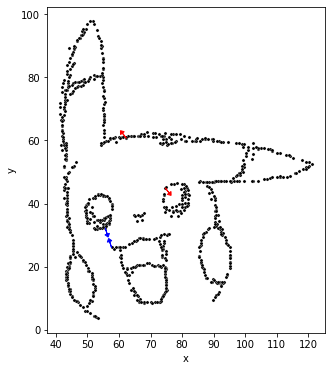

In [4]:
TopLayer = AlphaLayer(maxdim=1) # alpha complex layer
TopLoss = DiagramLoss(dim=1, j=1, g=g3) # explore gradients for both birth and death times using g3
def top_loss(output):
    dgminfo = TopLayer(output)            
    loss = TopLoss(dgminfo)
    
    return loss

# Obtain the gradients for the first optimization step
Y = torch.autograd.Variable(torch.tensor(np.array(data)).type(torch.float), requires_grad=True)
optimizer = torch.optim.Adam([Y])
loss = top_loss(Y)
loss.backward()
grad = Y.grad.numpy()
Y = Y.detach()
del(Y)

# Determine the paired points (they have negated gradients)
critical_points = np.where(~np.any(grad==0, axis=1))[0]
groups = {}
counter = 0
for idx, g1 in enumerate(grad[critical_points,:]):
    group = np.where([np.all(g1 == -g2) for g2 in grad[critical_points[:idx,],:]])[0]
    if len(group):
        groups[critical_points[idx]] = groups[critical_points[int(group)]]
    else:
        groups[critical_points[idx]] = counter
        counter += 1

# Plot the nonzero gradients on the point cloud
grad_scale = -2 # better visualize the direction of the gradients
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x="x", y="y", ax=ax, color="black", s=10)
for idx in critical_points:
    plt.arrow(data.loc[idx, "x"], data.loc[idx, "y"], grad_scale * grad[idx, 0], grad_scale * grad[idx, 1],
             color=["red", "blue"][groups[idx]], linewidth=1, head_width=1.5, head_length=1)
ax.set_aspect("equal", "box")
plt.savefig("PikaGrad.png", dpi=200, bbox_inches='tight')
plt.show()

In [5]:
def g1(p): return -p[1] # function that returns the negative death time -d of a point (b, d)
def g2(p): return p[0] # function that returns the birth time b of a point (b, d)
def g3(p): return p[0] - p[1]  # function that returns the negative persistence b - d of a point (b, d)

We now conduct topological optimization for the various topological loss functions, which all increase persistence of the most singificant cycle in the point cloud.

In [6]:
Ys = list()

# Learning hyperparameters
num_epochs = 200
learning_rate = 1e-1

for idx, g in enumerate([g1, g2, g3]):
    # Construct topological loss function
    TopLoss = DiagramLoss(dim=1, j=1, g=g)
    def top_loss(output):
        dgminfo = TopLayer(output)
        #print(g)
        #print(g(dgminfo[0][1][0:1]))     
        loss = TopLoss(dgminfo)
        return loss
    
    # Conduct topological optimization
    print("\033[1mPerforming topological optimization for loss function " + str(idx + 1) + "\033[0m")
    Y = torch.autograd.Variable(torch.tensor(np.array(data)).type(torch.float), requires_grad=True)
    optimizer = torch.optim.Adam([Y], lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = top_loss(Y)
        loss.backward()
        optimizer.step()

        if epoch == 0 or (epoch + 1) % int(num_epochs / 10) == 0:
            print ("[epoch %d] [topological loss: %f]" % (epoch + 1, loss.item()))
    
    if idx < 2: print("\n")
    
    Ys.append(Y.detach().numpy())

Performing topological optimization for loss function 1
[epoch 1] [topological loss: -20.019480]
[epoch 20] [topological loss: -21.861126]
[epoch 40] [topological loss: -23.505850]
[epoch 60] [topological loss: -26.145042]
[epoch 80] [topological loss: -23.798954]
[epoch 100] [topological loss: -27.164900]
[epoch 120] [topological loss: -28.907946]
[epoch 140] [topological loss: -28.288908]
[epoch 160] [topological loss: -29.969337]
[epoch 180] [topological loss: -28.733551]
[epoch 200] [topological loss: -31.898052]


Performing topological optimization for loss function 2
[epoch 1] [topological loss: 6.470756]
[epoch 20] [topological loss: 3.891460]
[epoch 40] [topological loss: 2.395216]
[epoch 60] [topological loss: 1.887672]
[epoch 80] [topological loss: 1.620228]
[epoch 100] [topological loss: 1.664905]
[epoch 120] [topological loss: 1.596051]
[epoch 140] [topological loss: 1.526820]
[epoch 160] [topological loss: 1.540002]
[epoch 180] [topological loss: 1.503371]
[epoch 200] [to

We view the topologically optimized point clouds.

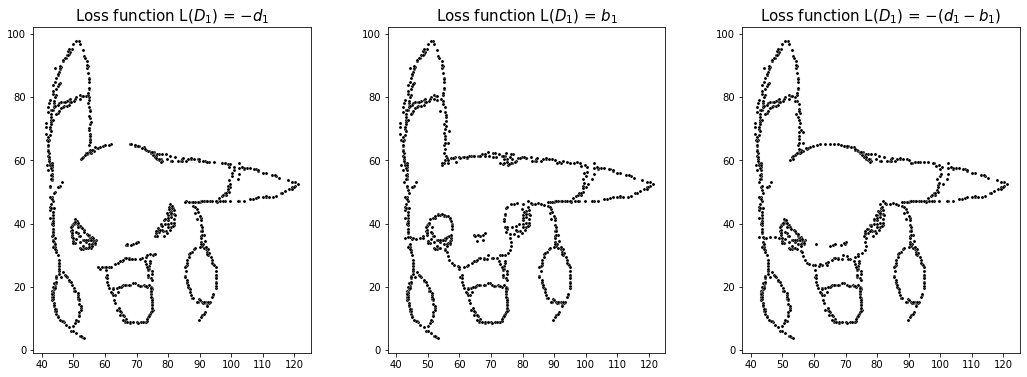

In [7]:
titles = ["Loss function L($D_1$) = " + l for l in ["$-d_1$", "$b_1$" , "$-(d_1 - b_1)$"]]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for idx in range(3):
    sns.scatterplot(data=data, x=Ys[idx][:,0], y=Ys[idx][:,1], ax=axes[idx], color="black", s=10)
    axes[idx].set_title(titles[idx],fontsize=15)
    axes[idx].set_aspect("equal", "box")
plt.savefig("PikaOpt.png", dpi=200, bbox_inches='tight')
plt.show()